<img align="right" width="250" src="http://www.sobigdata.eu/sites/default/files/logo-SoBigData-DEFINITIVO.png">
**Author:** [Riccardo Guidotti](http://kdd.isti.cnr.it/people/riccardo-guidotti)  
**Python version:**  3.x

<img align="right" width="300" src="https://upload.wikimedia.org/wikipedia/it/5/53/TitanicFilm.jpg">
# Titanic Case Study
The sinking of the Titanic is one of the most infamous shipwrecks in history. On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

In this notebook, we will try to figure out what sorts of people were likely to survive by using ***clustering*** in python.

The **Titanic** dataset became famous after that ***Kaggle*** launched the competition to discover label the passengers as survived or not by exploiting some available features ([link](https://www.kaggle.com/c/titanic)).

### Library import

### Dataset load and features semantics

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

### KDD Process
1. Dataset load and features semantics
1. Data Cleaning (handle missing values, remove useless variables)
1. Feature Engineering
1. Clustering Preprocessing (feature reshaping, normalization)
1. Parameter Tuning
1. Perform Clustering
1. Analyze the clustering results
1. Are the clusters useful to understand survival? 

In [2]:
df = pd.read_csv("../dataset/titanic.csv", skipinitialspace=True, sep=',')

In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


Each record is described by 12 variables:

* The ``Survived`` variable is our outcome or dependent variable. It is a binary nominal datatype of 1 for survived and 0 for did not survive. All other variables are potential predictor or independent variables. It's important to note, more predictor variables do not make a better model, but the right variables.
* The ``PassengerID`` and ``Ticket`` variables are assumed to be random unique identifiers, that have no impact on the outcome variable. Thus, they will be excluded from analysis.
* The ``Pclass`` variable is an ordinal datatype for the ticket class, a proxy for socio-economic status (SES), representing 1 = upper class, 2 = middle class, and 3 = lower class.
* The ``Name`` variable is a nominal datatype. It could be used in feature engineering to derive the gender from title, family size from surname, and SES from titles like doctor or master. Since these variables already exist, we'll make use of it to see if title, like master, makes a difference.
* The ``Sex`` and ``Embarked`` variables are a nominal datatype. They will be converted to dummy variables for mathematical calculations.
* The ``Age`` and ``Fare`` variable are continuous quantitative datatypes.
* The ``SibSp`` represents number of related siblings/spouse aboard and ``Parch`` represents number of related parents/children aboard. Both are discrete quantitative datatypes. This can be used for feature engineering to create a family size and is alone variable.
* The ``Cabin`` variable is a nominal datatype that can be used in feature engineering for approximate position on ship when the incident occurred and SES from deck levels. However, since there are many null values, it does not add value and thus is excluded from analysis.

In [5]:
df.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Mellinger, Mrs. (Elizabeth Anne Maidment)",male,NaN,NaN,NaN,347082,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


### Data cleaning

Handle missing values

In [6]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

#df['Age'] = df['Age'].fillna(df['Age'].median(), inplace=True)
df['Age'] = df['Age'].groupby([df['Sex'], df['Pclass']]).apply(lambda x: x.fillna(x.median()))

Remove useless variables

In [8]:
survived = df['Survived']

column2drop = ['PassengerId', 'Name', 'Cabin', 'Embarked', 'Survived']
df.drop(column2drop, axis=1, inplace=True)

In [9]:
df.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare
0,3,male,22.0,1,0,A/5 21171,7.2500
1,1,female,38.0,1,0,PC 17599,71.2833
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250
3,1,female,35.0,1,0,113803,53.1000
4,3,male,35.0,0,0,373450,8.0500


### Feature Engineering

/Users/riccardo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


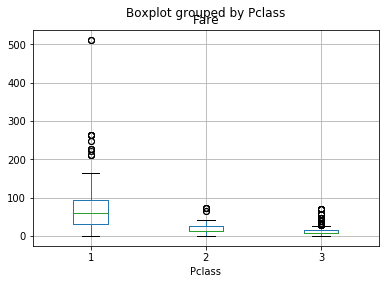

In [10]:
df.boxplot(['Fare'], by='Pclass', showfliers=True)
plt.show()

From a carefull data analysis emerges that the Fare is cumulative with respect to various Tickets with the same identifier. Consequently we proceed in correcting the Fare of each passenger by dividing it with the number of Tickets with the same identifier.

In [11]:
dfnt = df[['Pclass', 'Ticket']].groupby(['Ticket']).count().reset_index()
dfnt['NumTickets'] = dfnt['Pclass']
dfnt.drop(['Pclass'], axis=1, inplace=True)

In [12]:
dfnt.head()

,Ticket,NumTickets
0,110152,3
1,110413,3
2,110465,2
3,110564,1
4,110813,1


In [13]:
df = df.join(dfnt.set_index('Ticket'), on='Ticket')

In [14]:
df.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,NumTickets
0,3,male,22.0,1,0,A/5 21171,7.2500,1
1,1,female,38.0,1,0,PC 17599,71.2833,1
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,1
3,1,female,35.0,1,0,113803,53.1000,2
4,3,male,35.0,0,0,373450,8.0500,1


In [15]:
df['Fare'] = df['Fare']/df['NumTickets']

It is also important to consider the number of people a passenger is travelling with. 

In [16]:
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

The features NumTickets and Ticket helped in correcting Fare and we do not need theme any more.  
The features SibSp and Parch are redundant with respect to FamilySize.  

In [17]:
column2drop = ['SibSp', 'Parch', 'NumTickets', 'Ticket']
df.drop(column2drop, axis=1, inplace=True)

In [18]:
df.head()

,Pclass,Sex,Age,Fare,FamilySize
0,3,male,22.0,7.2500,2
1,1,female,38.0,71.2833,2
2,3,female,26.0,7.9250,1
3,1,female,35.0,26.5500,2
4,3,male,35.0,8.0500,1


### Clustering Preprocessing

Feature Reshaping

In [19]:
from sklearn.preprocessing import LabelEncoder

In [20]:
label_encoders = dict()
column2encode = ['Sex']

for col in column2encode:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [21]:
df.head()

,Pclass,Sex,Age,Fare,FamilySize
0,3,1,22.0,7.2500,2
1,1,0,38.0,71.2833,2
2,3,0,26.0,7.9250,1
3,1,0,35.0,26.5500,2
4,3,1,35.0,8.0500,1


Normalization

In [22]:
from sklearn.preprocessing import MinMaxScaler

In [23]:
scaler = MinMaxScaler()
X = scaler.fit_transform(df.values)

In [24]:
X[:5]

array([[ 1.        ,  1.        ,  0.27117366,  0.03269017,  0.1       ],
       [ 0.        ,  0.        ,  0.4722292 ,  0.32141562,  0.1       ],
       [ 1.        ,  0.        ,  0.32143755,  0.03573374,  0.        ],
       [ 0.        ,  0.        ,  0.43453129,  0.11971366,  0.1       ],
       [ 1.        ,  1.        ,  0.43453129,  0.03629736,  0.        ]])

### Parameter Tuning

In [25]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [26]:
sse_list = list()
max_k = 50
for k in range(2, max_k + 1):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(X)
    
    sse = kmeans.inertia_
    sse_list.append(sse)

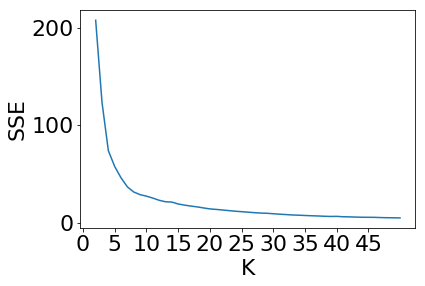

In [27]:
plt.plot(range(2, len(sse_list) + 2), sse_list)
plt.ylabel('SSE', fontsize=22)
plt.xlabel('K', fontsize=22)
plt.xticks(np.arange(0, 50, 5))
plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

### Perform Clustering

In [28]:
kmeans = KMeans(n_clusters=5, n_init=10, max_iter=100)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [29]:
print('Silhouette %s' % silhouette_score(X, kmeans.labels_))

Silhouette 0.585626856046


### Analyze the clustering results

Observing the size of each cluster

In [30]:
hist, bins = np.histogram(kmeans.labels_, bins=range(0, len(set(kmeans.labels_)) + 1))
sizes = dict(zip(bins, hist))

for id_cluster, size in sizes.items():
    print('Cluster %d: %d (%.2f)' % (id_cluster, size, size/len(X)))

Cluster 0: 347 (0.39)
Cluster 1: 170 (0.19)
Cluster 2: 122 (0.14)
Cluster 3: 144 (0.16)
Cluster 4: 108 (0.12)


Visualization of the clustering in two dimensions.

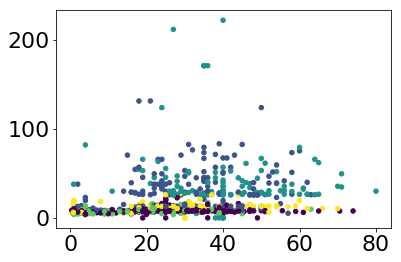

In [31]:
plt.scatter(df['Age'], df['Fare'], c=kmeans.labels_, s=20)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

Centers

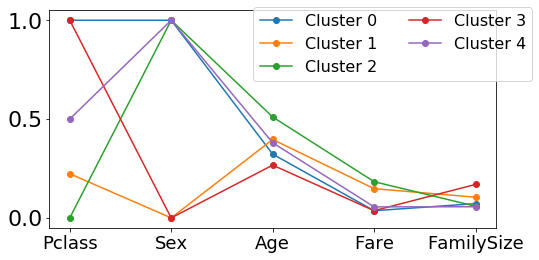

In [32]:
centers = kmeans.cluster_centers_

plt.figure(figsize=(8, 4))
for i in range(0, len(centers)):
    plt.plot(centers[i], marker='o', label='Cluster %s' % i)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.xticks(range(0, len(df.columns)), df.columns, fontsize=18)
plt.legend(fontsize=16, ncol=2, bbox_to_anchor=(1.1, 1.05))
plt.show()

In [33]:
pd.crosstab(df['Pclass'], kmeans.labels_)

col_0,0,1,2,3,4
Pclass,,,,,
1,0,94,122,0,0
2,0,76,0,0,108
3,347,0,0,144,0


In [34]:
pd.crosstab(df['Sex'], kmeans.labels_)

col_0,0,1,2,3,4
Sex,,,,,
0,0,170,0,144,0
1,347,0,122,0,108


### Are the clusters useful to understand survival?

In [35]:
df['Survived'] = survived
df['Label'] = kmeans.labels_

for col in column2encode:
    le = label_encoders[col]
    df[col] = le.inverse_transform(df[col])

In [36]:
pd.crosstab(df['Survived'], df['Label'])

Label,0,1,2,3,4
Survived,,,,,
0,300,9,77,72,91
1,47,161,45,72,17


In [37]:
df[df['Label']==4].describe(include='all')

,Pclass,Sex,Age,Fare,FamilySize,Survived,Label
count,108.0,108,108.000000,108.000000,108.000000,108.000000,108.0
unique,NaN,1,NaN,NaN,NaN,NaN,NaN
top,NaN,male,NaN,NaN,NaN,NaN,NaN
freq,NaN,108,NaN,NaN,NaN,NaN,NaN
mean,2.0,NaN,30.678981,12.403735,1.564815,0.157407,4.0
std,0.0,NaN,14.159550,4.993974,0.888905,0.365882,0.0
min,2.0,NaN,0.670000,0.000000,1.000000,0.000000,4.0
25%,2.0,NaN,23.000000,10.500000,1.000000,0.000000,4.0
50%,2.0,NaN,30.000000,13.000000,1.000000,0.000000,4.0
75%,2.0,NaN,36.000000,13.500000,2.000000,0.000000,4.0
